<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S76_drone_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dataclasses import dataclass

import plotly
import torch
import torch.nn as nn
import torch.optim as optim
import json
import PIL
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

DEVICE = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

# Neural Radiance Fields for Drones

<img src="Figures7/S76-Autonomous_camera_drone-07.jpg" alt="Splash image with a drone-like robot, steampunk style" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

## What is a NeRF?

In the previous section we have seen how a density field can assist in planning drone trajectories while avoiding obstacles. In this section we will examine how to learn such maps from data.

A **neural radiance field** of "NeRF" is a neural representation of a 3D scene, and hence can be very useful for drones to help with motion planning, obstacle avoidance, or even simply simulation of drone flights. NeRFs were introduced in the field of computer vision in 2020 by a team of researchers from Berkeley and Google, and have since seen an explosion of interest. The reasons are two-fold:

- their proposed scheme of learning a neural representation of the 3D scene was very simple
- the resulting NeRFs were capable of generating very realistic "renderings" of the learned scene

In a nutshell, given a large set of images taken of a 3D scene, the original NeRF trained a large (but simple) neural network to predict the value of every pixel in every image. By doing so, the neural network could then also *generate* new images that were not in the original training set. What is more, the neural network can also be used to predict the 3D structure of the underlying scene, making it possible to do much more than simply view synthesis.

The original NeRF paper (Mildenhall et al., ECCV 2020) was rather slow, because of the large neural network used. Since then, however, faster *voxel-based* versions have been developed. In this chapter, we first introduce a 1D version of this basic scheme, then move on to 3D (voxels), and finally show how it can be used to create a neural *radiance* field.

## A Differentiable Voxel Grid

A neural radiance field will predict density and color in 3D, and we can build upon the 1D interpolation example that we introduced in Section 5.6. The key is to create a *differentiable* interpolation scheme, that we can then *train* using samples from the function we want to interpolate.

Let us recall the training code from Chapter 5 to minimize a Mean-Squared Error (MSE) loss function, i.e., the squared difference between the predicted values and the training data values. In other words, we regard NeRF as a standard continuous *regression* problem.

In [6]:
def train(model, x_samples, y_samples, learning_rate=0.3, num_epochs=601, checkpoint_freq=100):
    # Initialize Stochastic Gradient Descent optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize the built-in Mean-Squared Error loss function
    mse = nn.MSELoss()

    # Loop over the dataset multiple times (each loop is an epoch)
    for epoch in range(num_epochs):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x_samples through the model
        output = model(x_samples)

        # Compute loss using built-in MSE loss function
        loss = mse(output, y_samples)

        # Backward pass: Compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update model parameters using optimizer
        optimizer.step()

        # Print loss at specified checkpoint frequencies
        if epoch % checkpoint_freq == 0:
            print(f'Loss at epoch {epoch}: {loss.item()}')


The scheme above can be easily used with 3D voxel grids, although the interpolation function has to be changed from simple linear interpolation over an interval, to **trilinear interpolation** on voxels. The code below implements this, and it really is not that complicated: the values on the *eight* corners of each voxel are combined using three blending weights, depending on where the queried point lies within that voxel:

In [9]:
class VoxelGrid(nn.Module):
    def __init__(self, shape, d=1):
        """A 3D voxel grid with given `shape` with learnable values at the corners of the voxels."""
        super(VoxelGrid, self).__init__()
        self.grid = nn.Parameter(nn.init.normal_(torch.empty(*shape, d)))


    def forward(self, p):
        x, y, z = p[..., 0], p[..., 1], p[..., 2]
        X, Y, Z = torch.floor(x).long(), torch.floor(y).long(), torch.floor(z).long()
        a, b, c = x - X, y - Y, z - Z # blending weights along each axis

        # clamp indices to grid size:
        Xp = torch.clamp(X + 1, max=self.grid.shape[0] - 1)
        Yp = torch.clamp(Y + 1, max=self.grid.shape[1] - 1)
        Zp = torch.clamp(Z + 1, max=self.grid.shape[2] - 1)

        c00 = interpolate(self.grid[Z, Y, X, :], self.grid[Z, Y, Xp, :], a)
        c01 = interpolate(self.grid[Z, Yp, X, :], self.grid[Z, Yp, Xp, :], a)
        c10 = interpolate(self.grid[Zp, Y, X, :], self.grid[Zp, Y, Xp, :], a)
        c11 = interpolate(self.grid[Zp, Yp, Xp, :], self.grid[Zp, Yp, X, :], a)

        c0 = interpolate(c00, c01, b)
        c1 = interpolate(c10, c11, b)
        
        return interpolate(c0, c1, c).squeeze(-1)

The VoxelGrid effectively defines a parameterized function in 3D. when we query it, we need to provide 3D coordinates. For example, the code below initializes a VoxelGrid with random values, and then evaluates the a scalar function at a 3D point:

In [10]:
voxel_grid_module = VoxelGrid(shape=(6, 6, 6), d=1)

point = torch.Tensor([1.5, 2.7, 3.4])
output = voxel_grid_module(point)
print("Interpolated Output:", output)


Interpolated Output: tensor(0.2236, grad_fn=<SqueezeBackward1>)


However, the code is much more powerful than this. As an example, below we create a grid with a 4D function, and evaluate it at a 2x2 batch of 3d points:

In [11]:
voxel_grid_module = VoxelGrid(shape = (6, 6, 6), d=4)

points = torch.Tensor([[[1.5, 2.7, 3.4], [2.3, 4.6, 1.1]], [[2.3, 4.6, 1.1], [2.3, 4.6, 1.1]]])
output = voxel_grid_module(points)
print("Interpolated Output:", output.shape)
print("Interpolated Output:", output)

Interpolated Output: torch.Size([2, 2, 4])
Interpolated Output: tensor([[[-0.0238, -0.0919,  0.2214,  0.1476],
         [ 0.2544,  0.9916,  0.0892, -0.1090]],

        [[ 0.2544,  0.9916,  0.0892, -0.1090],
         [ 0.2544,  0.9916,  0.0892, -0.1090]]], grad_fn=<SqueezeBackward1>)


Being able to handle large batches of points is crucial when training with stochastic gradient descent, and especially when training a NeRF, which we finally get to in the section below.

## Differentiable Rendering

For NeRF, we need to add volume rendering.
The Renderer class below is responsible for rendering 3D objects in a scene based on how light interacts with them. It contains two main functions: `sample_along_ray` and `render`.

In [12]:
class Renderer:
    """Class for rendering 3D scenes into 2D images."""
    
    def __init__(self, num_samples=32, near=0.0, far=1.0, background=(0., 0., 0.)):
        """Initialize renderer with parameters."""
        t_vals = torch.linspace(0., 1., num_samples + 1)
        self.t_vals = near * (1. - t_vals) + far * t_vals
        self.t_mids = 0.5 * (self.t_vals[1:] + self.t_vals[:-1])
        self.background = background

    def sample_along_ray(self, origins, directions):
        """Sample points along rays defined by origins and directions."""
        norms = torch.norm(directions, dim=-1, keepdim=True)
        scaled_t_mids = self.t_mids * norms
        depths = self.t_vals * norms
        samples = origins[..., None, :] + scaled_t_mids[..., None] * directions[..., None, :]
        return depths, samples

    def render(self, depths, density, rgb):
        """Compute the final rendered color given the depths, density, and RGB values."""
        distances = depths[..., 1:] - depths[..., :-1]
        
        # Add extra dimensions to distances for broadcasting
        extra_dims = len(density.shape) - len(distances.shape)
        for _ in range(extra_dims):
            distances = distances[..., None]

        density_delta = density * distances
        alpha = 1 - torch.exp(-density_delta)
        trans = torch.exp(-torch.cat([torch.zeros_like(density_delta[..., :1]), 
                                      torch.cumsum(density_delta[..., :-1], dim=-1)], dim=-1))

        weights = alpha * trans
        color_acc = torch.einsum('...i,...ij->...j', weights, rgb)
        acc = weights.sum(dim=-1, keepdim=True)

        return color_acc + (1.0 - acc) * torch.tensor(self.background)

The `Renderer` class is designed to "render" or create 2D images from 3D data, specifically "density" and "color". It has methods for sampling points along rays and for rendering a final image.

#### `__init__` Method

When you create an object of this class, this method sets up all the basic parameters like the number of samples to consider (`num_samples`), the near and far limits (`near` and `far`), and the background color (`background`).

#### `sample_along_ray` Method

Given starting points (`origins`) and directions (`directions`) for rays in 3D space, this method calculates where to sample along each ray. It returns the "depths" (distance from the origin) and "samples" (the actual 3D coordinates of these points).

#### `render` Method

This method takes in "depths," "density," and RGB color values for the sampled points and calculates what the final color of each ray should be.

Here's a bit more detail on some specific steps:

1. **Distances between adjacent samples:** It calculates the distances between adjacent depths (points we sampled along the ray).

2. **Density Delta:** It calculates `density_delta`, which is essentially how much "stuff" is between each adjacent sample. This is used to understand how the light interacts with the material as it passes through.

3. **Alpha and Transmittance:** It calculates how much light gets absorbed (`alpha`) and how much gets transmitted (`trans`) at each sample along the ray.

4. **Weights:** Combines `alpha` and `trans` to form the "weights" for each sample, which dictate how much each sample contributes to the final color.

5. **Final Color:** The final color (`color_acc`) for each ray is calculated using these weights and the given RGB values.

6. **Background Mixing:** The function finally mixes the calculated color with the background color, taking into account how much each ray is occluded by objects.


In [13]:
# Initialize renderer
renderer = Renderer()

# Create an example set of 2x2 ray origins and directions
ray_origins = torch.tensor([[[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]],
                            [[0.7, 0.8, 0.9], [0.1, 0.2, 0.3]]])

ray_directions = torch.tensor([[[0.3, 0.2, 0.1], [0.6, 0.5, 0.4]],
                               [[0.9, 0.8, 0.7], [0.3, 0.2, 0.1]]])

# Sample points along the rays
depths, samples = renderer.sample_along_ray(ray_origins, ray_directions)
print("Depth tensor shape:", depths.shape)
print("Samples tensor shape:", samples.shape)

# Take these and render
density = torch.ones((2, 2, 32))
rgb = torch.ones((2, 2, 32, 3))
predicted = renderer.render(depths, density, rgb)

# Verify shape of the output
print("Predicted tensor shape:", predicted.shape)


Depth tensor shape: torch.Size([2, 2, 33])
Samples tensor shape: torch.Size([2, 2, 32, 3])
Predicted tensor shape: torch.Size([2, 2, 3])


We can now define a simple DVGO (Direct Voxel Grid Optimization, see XXX et al.) class by inheriting from this renderer:

In [14]:
import torch.nn.functional as F

class SimpleDVGO(nn.Module):
    def __init__(self, shape=(128, 128, 128), min_corner=(-1, -1, -1), max_corner=(1, 1, 1)):
        """Initialize voxel grids and bounding box corners."""
        super(SimpleDVGO, self).__init__()
        self.shape = shape
        self.renderer = Renderer()
        self.rgb_voxel_grid = VoxelGrid(self.shape, d=3)
        self.density_voxel_grid = VoxelGrid(self.shape, d=1)
        self.min_corner = torch.tensor(min_corner, dtype=torch.float32)
        self.max_corner = torch.tensor(max_corner, dtype=torch.float32)

    def grid_from_scene(self, p):
        """Rescale coordinates based on the grid dimensions."""
        scale = 1.0 / (self.max_corner - self.min_corner)
        unclamped = (p - self.min_corner) * scale
        return torch.clamp(unclamped, 0.0, 0.9999999) * torch.tensor(self.shape).float()
        
    def forward(self, x_samples):
        """Perform volume rendering using the provided ray information."""
        # Extract ray origins and directions from x_samples
        origins = x_samples[..., :3]
        directions = x_samples[..., :3]

        # Sample along the ray
        depths, samples = self.renderer.sample_along_ray(origins, directions)

        # Rescale to fit within the grid
        rescaled = self.grid_from_scene(samples)

        # Query Density Voxel Grid
        density = F.softplus(torch.squeeze(self.density_voxel_grid(rescaled)))
        
        # Query RGB Voxel Grid
        rgb = torch.sigmoid(self.rgb_voxel_grid(rescaled))

        # Render
        return self.renderer.render(depths, density, rgb)
        return y_samples


In [15]:
# Initialize your SimpleDVGO model
model = SimpleDVGO()

# Combine ray origins and directions into one tensor to use as x_samples
# Concatenate along the last dimension (-1)
x_samples = torch.cat((ray_origins, ray_directions), dim=-1)
print("x_samples shape:", x_samples.shape)

predicted = model(x_samples)
assert predicted.shape == (2, 2, 3)

# Create a corresponding set of 3 target RGB colors
# Each one is a 3D RGB color; assume they're randomly initialized here
y_samples = torch.tensor([[[0.3, 0.2, 0.1], [0.6, 0.5, 0.4]],
                          [[0.9, 0.8, 0.7], [0.3, 0.2, 0.1]]])

# Train the model
train(model, x_samples, y_samples)


x_samples shape: torch.Size([2, 2, 6])
Loss at epoch 0: 0.07794281095266342


Loss at epoch 100: 0.05535649135708809
Loss at epoch 200: 0.04292755201458931
Loss at epoch 300: 0.036507196724414825
Loss at epoch 400: 0.03282701596617699
Loss at epoch 500: 0.030484728515148163
Loss at epoch 600: 0.02886556275188923


### Training a NeRF with images

Now that we built the basic infrastructure to render a NeRF and regress it from data, let us apply it to real images. To do this, we will need two distinct pieces of information:

- the actual images themselves
- accurate geometry from where the images were taken

The latter is important because, as we saw above, a NeRF is trained with a set of *rays*. For a given image, every pixel in the image corresponds to a ray. The *origin* of the ray is exactly the optical center of the camera used to acquire the image, so we need at least that information. But to calculate, for every pixel, the *direction* of the ray needs a lot more. In fact, this is typically a two step process:

- the *intrinsic* calibration of the camera, most importantly the focal length, tells us how to convert pixel coordinates into a direction in the camera frame.
- the *extrinsic* calibration, position and orientation with which the image was taken, is needed to transform directions in the camera frame into the scene coordinate frame.

Acquiring all this information for an arbitrary image sequence taken with some unknown, uncalibrated camera can be complicated. Cameras come in a variety of sizes and with very different lenses, and effects like radial distortion make the modeling process non-trivial. In addition, recovering the actual position and attitude of the camera in a scene is typically done through structure from motion, which can be time-consuming and tricky.


In the following, we will assume that all this hard work has been done for us, and/or the images have been simulated with exactly known camera parameters, both intrinsic and extrinsic. One popular way to accomplish this is by proving undistorted images accompanied by a $3 \times 4$ **camera matrix** $M$. Recall that a 3D point $P$ can be projected into an image via

$$
\tilde{p} = K R^T (P - t)
$$

where $\tilde{p}$ are *homogeneous$ 2D image coordinates. We can re-write this as

$$
\tilde{p} = M\tilde{P}
$$

where $\tilde{P} = \begin{bmatrix}P \\1 \end{bmatrix}$ and the camera matrix $M$ is given by

$$
M = [A|a] = [K R^T | - K R^T t]
$$

That means that if we are *given* the camera matrix $M$ we can always recover the ray origins as 
$$
t = -A^{-1} a
$$

and a random 3D point $P$ on the ray corresponding to $\tilde{p}$ as

$$
P = A^{-1}(\tilde{p} - a)
$$

since $\tilde{p} = AP + a$. We will illustrate this below with an actual dataset.

### A simulated dataset

<figure>
<img src="stonehenge/train/render47.png" id="fig:stonehenge" style="width:14cm" alt="">
<figcaption>One of the synthetically generated images from the stonehenge dataset.</figcaption>
</figure>

In particular, we will use a dataset generated by Stanford researchers using Blender, using a simple 3D model of the Stonehenge monument in England. The dataset was originally published as part of the [Stanford NeRF Navigation project](https://mikh3x4.github.io/nerf-navigation/), and consists of 500 images, split into 200 images for training, and then validation and tests sets of 150 images each. One of the training images is shown above. The code below illustrates how to read the image into memory and display it:

In [16]:
def read_training_image(index:int):
    """Read image from the stonehenge dataset, and return as a PIL image."""
    # url = f"https://raw.githubusercontent.com/gtbook/robotics/main/Figures5/{image_name}"
    # return PIL.Image.open(requests.get(url, stream=True).raw)
    return PIL.Image.open(f"stonehenge/train/render{index}.png")

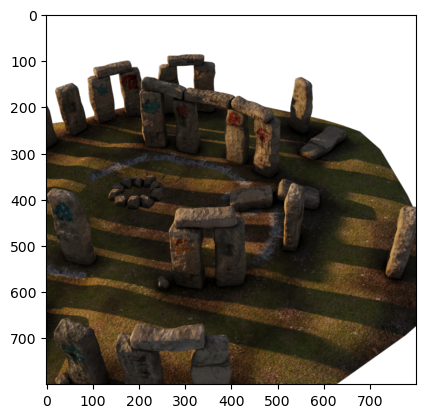

In [17]:
image = read_training_image(47)
plt.imshow(image);

Feel free to modify the index above and examine any of the other 198 images in the training set. The camera matrices are all given in a json file, which we can parse into a python dictionary:

In [18]:
# Open the local JSON file and read its content
with open("stonehenge/transforms_train.json", "r") as file:
    data = json.load(file)

# Now, `data` contains the parsed JSON content.
print(data)  # For verification


{'Far': 3.5, 'Near': 1.5, 'camera_angle_x': 0.6911112070083618, 'frames': [{'transform_matrix': [[0.890663743019104, -0.026803040876984596, 0.4538719058036804, 1.134679731443595], [0.45466262102127075, 0.05250595882534981, -0.8891147375106812, -2.2227868575679617], [0.0, 0.9982608556747437, 0.058951497077941895, 0.14737873955980724], [0.0, 0.0, 0.0, 1.0]], 'file_path': './train/render0'}, {'transform_matrix': [[0.7152658700942993, -0.06251849979162216, 0.6960504055023193, 1.740126070427181], [0.6988524794578552, 0.06398681551218033, -0.7123979926109314, -1.780995027497937], [0.0, 0.995990514755249, 0.08945879340171814, 0.22364697862318692], [0.0, 0.0, 0.0, 1.0]], 'file_path': './train/render1'}, {'transform_matrix': [[0.9617491364479065, -0.03087027184665203, 0.27218684554100037, 0.6804671252137209], [0.2739318311214447, 0.10838264226913452, -0.9556226134300232, -2.389056493074329], [0.0, 0.9936298131942749, 0.11269325762987137, 0.2817331439549869], [0.0, 0.0, 0.0, 1.0]], 'file_path': 

The camera matrix associated with the image below can then be extracted by converting to numpy:

In [19]:
def calculate_intrinsics(image_size: tuple, camera_angle_x: float) -> np.ndarray:
    """Calculate the intrinsic matrix given the image size and camera angle."""
    W, H = image_size
    f = W / (2 * np.tan(camera_angle_x/2))
    return np.array([[f, 0, W/2], [0, f, H/2], [0, 0, 1]])

def extract_extrinsics(data: dict, index: int) -> np.ndarray:
    """Extract the extrinsic matrix from the given data."""
    wTc = np.array(data["frames"][index]["transform_matrix"]) # Make sure to use the index parameter
    t = wTc[:3, 3] # translation
    R = wTc[:3, :3] # rotation
    return np.hstack((R.T, -R.T @ t.reshape(-1, 1)))

def read_json_data(filepath: str) -> dict:
    """Read the JSON data from a given filepath."""
    with open(filepath, "r") as file:
        return json.load(file)

def read_camera_matrix(index:int, image_size: tuple) -> np.ndarray:
    """Read the 3x4 camera matrix associated with a training image."""
    data = read_json_data("stonehenge/transforms_train.json")
    K = calculate_intrinsics(image_size, data['camera_angle_x'])
    M = extract_extrinsics(data, index)
    return K @ M


In [20]:
M = read_camera_matrix(47, image.size)
print(M.shape)
print(M)

(3, 4)
[[ 1.15284571e+03  1.68781519e+01  2.55400872e+02 -1.00000004e+03]
 [-1.12882724e+02  3.85407651e+02  1.11053415e+03 -1.00000005e+03]
 [ 2.16327354e-01 -7.38591552e-01  6.38502181e-01 -2.50000005e+00]]


In [21]:
data = read_json_data("stonehenge/transforms_train.json")
calculate_intrinsics(image.size, data['camera_angle_x'])


array([[1.11111103e+03, 0.00000000e+00, 4.00000000e+02],
       [0.00000000e+00, 1.11111103e+03, 4.00000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

We can then calculate the ray origin and ray direction for any pixel:

In [22]:
A, a = M[:, :3], M[:, 3]
t = -np.linalg.inv(A) @ a
p_ = np.array([2.5, 1.5, 1])
P = np.linalg.inv(A) @ (p_ - a)
D = P / np.linalg.norm(P)
print(t, D)

[ 0.54081839 -1.84647882  1.59625544] [ 0.13521586 -0.82155225  0.55386692]


In [23]:
def calculate_rays(M: np.ndarray, image_size: tuple) -> tuple:
    """Calculate a batch of rays associated with every pixel in a given image."""
    W, H = image_size
    A, a = torch.from_numpy(M[:, :3]), torch.from_numpy(M[:, 3])
    inv_A = torch.inverse(A)

    # Compute origin and expand to all pixels.
    t = -inv_A @ a
    ones = torch.ones((H, W))
    T = torch.einsum('i,hw->hwi', t, ones) # creates (H,W,3) batch
    
    # Batch compute directions for all pixels.
    x, y = torch.meshgrid(torch.linspace(0.5, W-0.5, W), torch.linspace(0.5, H-0.5, H), indexing='xy')
    p_ = torch.stack([x, y, ones], dim=-1)
    P = torch.einsum('ij,hwj->hwi', inv_A, p_ - a) # batch matrix multiply

    norms = -torch.linalg.norm(P, dim=-1, keepdim=True)
    D = P / (norms + 1e-8)

    return T, D

Let's try this for a simple 4x3 image (where 4 is width and 3 is height), and check that the batch dimensions are as we expect (height, width, 3), and that for the center pixel they agree with our manual calculation:

In [24]:
origins, directions = calculate_rays(M, (5, 3))
assert origins.shape == (3, 5, 3)
assert directions.shape == (3, 5, 3)
assert np.allclose(origins[1, 2, :], t)
assert np.allclose(directions[1, 2, :], D)

AssertionError: 

In [ ]:
fig = go.Figure()
for i in range(0, 199, 10):
    M = read_camera_matrix(i, image.size)
    origins, directions = calculate_rays(M, image.size)
    T = origins[::100,::100,:].reshape(-1, 3)
    D = directions[::100,::100,:].reshape(-1, 3)

    # Adding line segments for each ray
    for start, end in zip(T, T + D):
        fig.add_trace(go.Scatter3d(x=[start[0], end[0]],
                                y=[start[1], end[1]],
                                z=[start[2], end[2]],
                                mode='lines',
                                line=dict(color='red')))

fig.update_layout(showlegend=False)
fig.show()
